# Using CodeGaze

Examples of the codegaze API. Install codegaze using pip:

```python
pip install codegaze
``` 

In [1]:
# !pip install codegaze

In [17]:
import os
import pandas as pd
from tqdm.notebook import tqdm
from codegaze import codeparser, metrics, codegen


In [18]:
block_parser = codeparser.CodeBlockParser()
edit_metric = metrics.EditMetric()
ast_metric = metrics.ASTMetric(parser=block_parser)
neural_metric = metrics.NeuralMetric()


## Computing Code Similarity


In [48]:
code = '''import requests
def get_ip():
    """Get my current external IP. Other line. """
    result = requests.get("https://icanhazip.com").text.strip() 
    holder = []
    for row in result:
        holder.append(row)
    return result
'''

code_blocks = block_parser.extract_blocks(code, max_lines_per_block=3)
a = code_blocks[1].text
b = code_blocks[2].text

edit = edit_metric.compute(a, b)
ast = ast_metric.compute(a, b)
neural = neural_metric.compute(a, b)

print(f"Edit distance: {edit}, AST distance: {ast}, Neural distance: {neural}")


Edit distance: 0.13559322033898302, AST distance: 1.0, Neural distance: 0.9303905963897705


## View AST Nodes in Code 

In [53]:
for block in code_blocks:
    print(f"** Node type: {block.type} | Node Text: {block.text}") 

** Node type: import_statement | Node Text: import requests
** Node type: expression_statement | Node Text: """Get my current external IP. Other line. """
** Node type: expression_statement | Node Text: result = requests.get("https://icanhazip.com").text.strip()
** Node type: expression_statement | Node Text: holder = []
** Node type: for_statement | Node Text: for row in result:
        holder.append(row)
** Node type: return_statement | Node Text: return result


## Generating Code Completions

- Support for OpenAI models
- Support for HuggingFace models


In [20]:
oai_model = codegen.OpenAICodeGenerator(name="oaimodel", model="code-cushman-001")
hf_model = codegen.HFCodeGenerator(
    name="salesforce350", model="Salesforce/codegen-350M-multi"
)
oai_completions = oai_model.generate(code, n=2)
hf_completions = hf_model.generate(code, n=2)


In [9]:
print(f"HF model completions: {hf_completions[0].text}")

HF model completions: 
def get_ip_from_file():
    """Get my current external IP from a file. Other line. """
    with open("/etc/hosts", "r") as f:
        result = f.readlines()
    return result

def get_ip_from_string(ip):
    """Get my current external IP from a string. Other line. """
    ip = ip.strip()
    if ip.startswith("127.0.0.1"):
        return ip
    else:
        return ip.split(".")[0]

def get_ip_from_ipv4(ip):
    """Get my current external IP from a string. Other line. """
    ip = ip.strip()
    if ip.startswith("127.0.0.1"):
        return ip
    else:
        return ip.


# Run and Analyze Experiment Results


In [32]:
from codegaze.experiment import Experiment
from codegaze.datamodel import ExperimentConfig
from codegaze.datasets import HumanEvalDataset
from codegaze.utils import get_dirs, load_json, save_json
import pandas as pd
import numpy as np

import seaborn as sns 
import matplotlib.pyplot as plt

In [42]:
def plot_cor(df, cor_method = "spearman", title="title"): 
    plt.figure(figsize=(18,10))
    sns.set(font_scale=1.4) 
    sns.heatmap(df.corr(method=cor_method), annot = True,cmap= 'coolwarm', annot_kws={"size":18});
    plt.title(title, fontsize=20);

In [45]:
data_path = "../experiments/data/"
exp = Experiment("general", data_path=data_path)
experiments = exp.list_experiments(dataset="humaneval")
experiment = experiments[0]
print("Working on experiment:", experiment.slug)
models = exp.list_models(experiment.dataset, experiment.slug)
model = models[1] 
print("Working on model:", model)

Working on experiment: 43a954ad66fa8f38b47041deb2f191bd685aa6fc
Working on model: ModelConfig(type='openai', name='code-cushman-001', description='OpenAI Codex Cushman 001 model trained on Github', temperature=0.8, suffix=False, n_completions=10, path='code-cushman-001', max_tokens=300)


In [28]:
def agg_results(exp_results):
    exp_list = []
    for metric_type in exp_results.keys():
        for metric in exp_results[metric_type].keys():
            exp_list.append({"metric_type": metric_type, "metric": metric, "value": exp_results[metric_type][metric]})
    exp_df = pd.DataFrame(exp_list)
    exp_df
    return exp_df 

def metrics_data(experiment, model, metric_type):    
    metrics, metrics_arr, problems = exp.load_metrics(experiment, model, metric_type=metric_type)
    return metrics, metrics_arr, problems

<Figure size 1296x720 with 0 Axes>

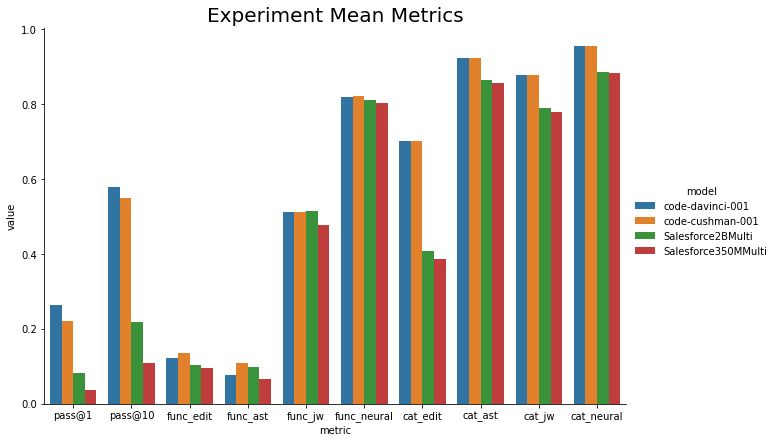

In [30]:
model_results = []
for model in models:
    metrics = exp.get_aggregate_results(experiment, model)
    for metric_type in metrics.keys():
        for metric in metrics[metric_type].keys():
            model_results.append({"metric_type": metric_type, "metric": metric, "value": metrics[metric_type][metric], "model": model.name}) 
results_df = pd.DataFrame(model_results)

plt.figure(figsize=(18,10))
sns.catplot(x="metric", y="value", hue="model", data=results_df, kind="bar", height=6, aspect=1.5);
plt.title(f"Experiment Mean Metrics", fontsize=20);

## Functional Eval Metrics Drill Down 

Drill down on metrics for a specific model

In [43]:
func, func_arr, problems = metrics_data(experiment, model, metric_type="function")
func_df = pd.DataFrame(func) 
func_df["problems"] = problems  
func_df.head(4)

,pass@1,pass@10,func_edit,func_ast,func_jw,func_neural,problems
0,0.0,0.0,0.136719,0.000000,0.495210,0.808982,HumanEval/77
1,0.0,0.0,0.200000,0.333333,0.552780,0.811400,HumanEval/25
2,0.0,0.0,0.014286,0.000000,0.512959,0.813823,HumanEval/123
3,0.7,1.0,0.172043,0.000000,0.579406,0.798962,HumanEval/53


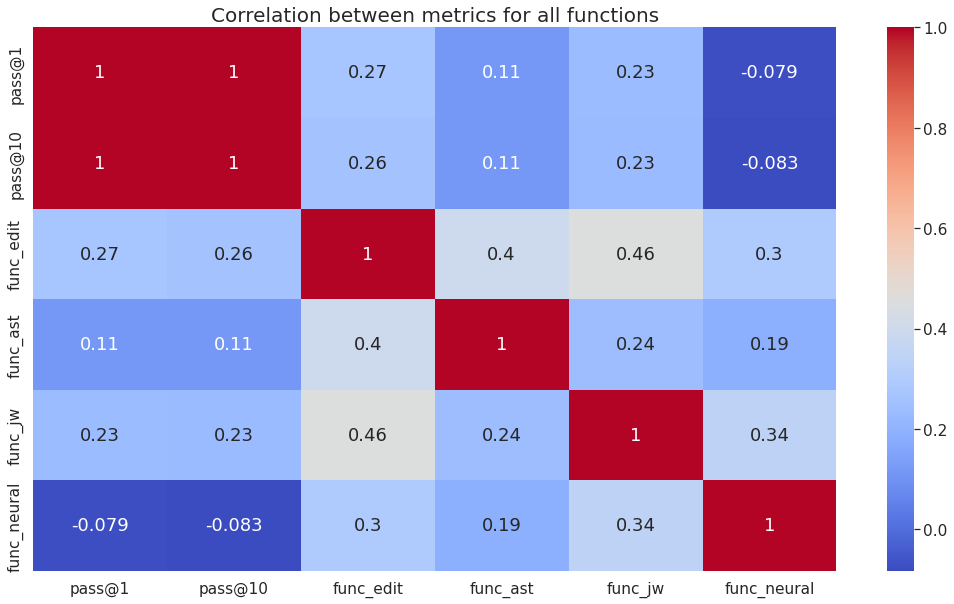

In [44]:
plot_cor(func_df, cor_method="spearman", title="Correlation between metrics for all functions")

## Cat Metrics Data Drill Down
Drill down on metrics for a specific model

- Show cat matrics for a model 
- Extract df with data ... also keeping track fo the character length for each block being replaced (used for normalization down the line)

In [34]:
cat_sum, cat_arr, problems = metrics_data(experiment, model, metric_type="cat")
cat_blocks = []
for row in cat_arr:
    for blocks in row:
        if len(blocks) == 0:
            continue 
        car_len = blocks[0]["cat_charlen"]["len_ex"]
        block_df = pd.DataFrame(blocks)
        block_df = dict(block_df.select_dtypes(include=np.number).max())
        block_df["type"] =  blocks[0]["type"]
        block_df["car_len"] = car_len 
        cat_blocks.append(block_df)
cat_df = pd.DataFrame(cat_blocks) 
print(f"Total number of blocks in the dataset: {len(cat_df)}")     
cat_df.head(5) 

Total number of blocks in the dataset: 498


,cat_edit,cat_ast,cat_jw,cat_neural,type,car_len
0,0.100000,1.0,0.730000,0.805074,expression_statement,10
1,0.142857,1.0,0.828571,0.782797,return_statement,42
2,0.636364,1.0,0.868531,0.930390,import_statement,11
3,0.900000,1.0,0.980000,0.949460,expression_statement,9
4,1.000000,1.0,1.000000,1.000000,expression_statement,5


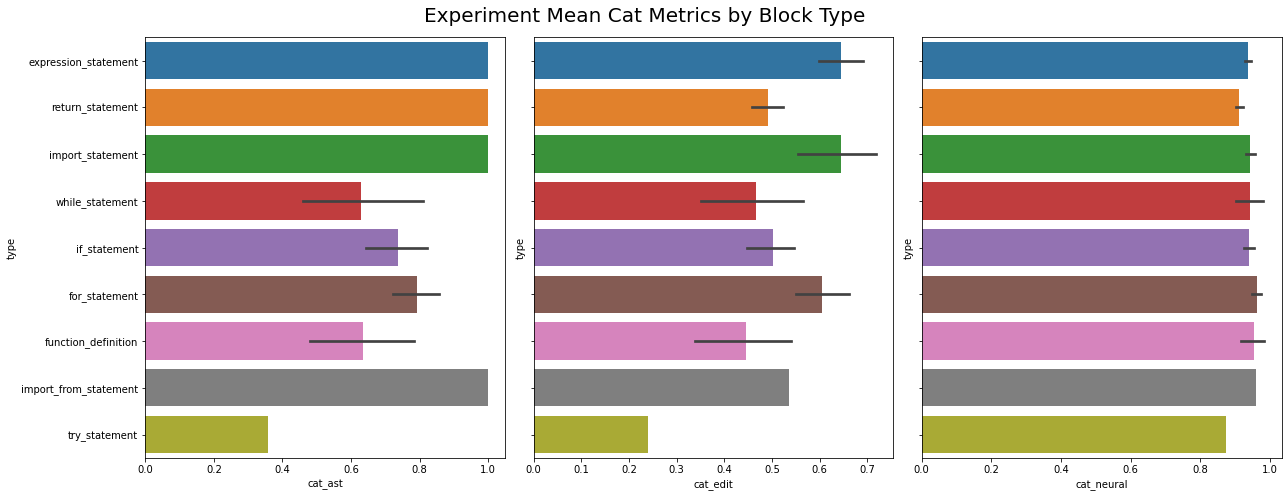

In [35]:
fig, axs = plt.subplots(ncols=3, sharey=True, figsize=(18,7)) 

sns.barplot(x="cat_ast", y="type", data=cat_df, ax=axs[0])
sns.barplot(x="cat_edit", y="type", data=cat_df, ax=axs[1])
sns.barplot(x="cat_neural", y="type", data=cat_df, ax=axs[2])
fig.suptitle(f"Experiment Mean Cat Metrics by Block Type", fontsize=20);
plt.tight_layout()

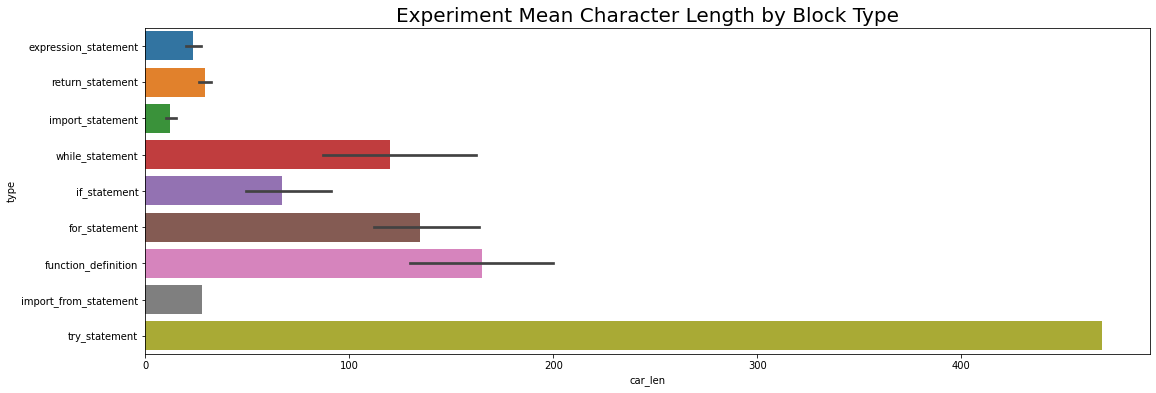

In [36]:
plt.figure(figsize=(18,6));
sns.barplot(x="car_len", y="type", data=cat_df, estimator=np.mean);
plt.title(f"Experiment Mean Character Length by Block Type", fontsize=20);

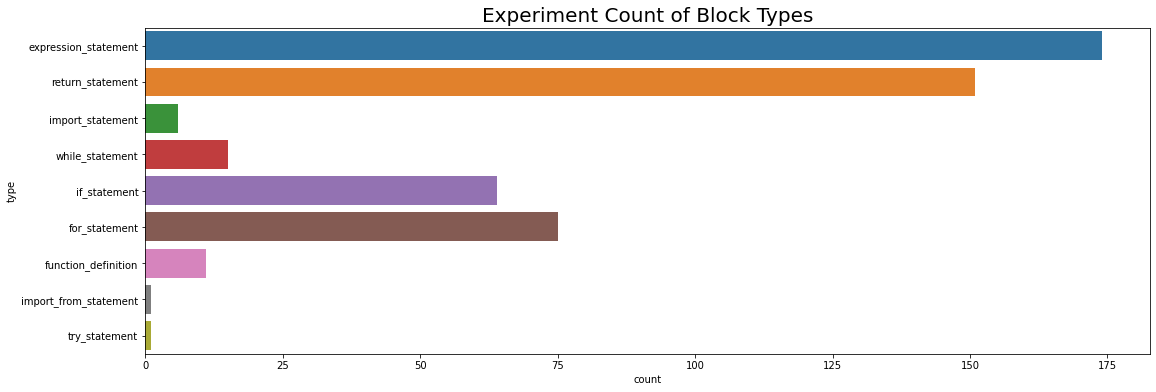

In [37]:
plt.figure(figsize=(18,6));
sns.countplot(y="type", data=cat_df);
plt.title(f"Experiment Count of Block Types", fontsize=20);